In [23]:
# all libraries needed
library(tidyverse)
library(tidymodels)
library(forcats)
library(repr)
library(dplyr)

### Predicting the age of the user

Introduction

Online games allow for an extensive amount of data to be collected on users for understanding user behavior. A research group in Computer Science at the University of British Columbia (UBC), led by Frank Wood, is collecting data from a custom Minecraft server to study how people play video games. They aim to optimize their project by targeting recruitment efforts and ensuring server resources are sufficient for the player base. To do this, they need to better understand the characteristics and behaviors of their players. This raises the question: can a player's engagement metrics, specifically the total number of sessions played and total hours played, be used to predict whether a player is an adult (18+) or underaged (under 18) in the UBC server dataset?

The analysis utilizes two datasets provided by the research group: players.csv, containing unique player attributes, and sessions.csv, containing records of individual play sessions.To prepare the data for analysis, the two datasets were combined based on the common hashedEmail variable. The goal was to isolate the total number of sessions for each player, their total play hours, and their age. An initial challenge arose during this process, as sessions.csv originally contained 1535 rows (representing individual sessions) while players.csv only contained 196 rows (representing unique players). This required sessions.csv to be joined with players.csv using a left_join(). Afterward, the resulting file was grouped by player and summarized into a concise dataset containing age, total play time, and number of sessions for each unique player.

Methods and Results

As mentioned above, the goal of this was to combine the two files in such a way that makes it easy to extrapolate useful data from. However, because I wanted to create a classification model, I did mutate the ages into age groups, making it a class. My thinking behind this was to create two distinct groups based on the amount of time they usually have for freetime (under 18 usually has more as they don't have work, university, and whatnot).

In [168]:
# wrangling
player_data <- read_csv('data/players.csv')
session_data <- read_csv('data/sessions.csv')

merged_player_data <- left_join(player_data, session_data, by = 'hashedEmail')

write.csv(merged_player_data, "merged_file.csv", row.names = FALSE)

final_data_players <- merged_player_data |>
    group_by(hashedEmail) |>
    summarize(num_sessions = n(), Age = first(Age), played_hours = first(played_hours)) |>
    mutate(age_group = if_else(Age < 18, "Underaged", "Adult")) |>
    mutate(age_group = as_factor(age_group)) |>
    select(-Age, - hashedEmail)

head(final_data_players, n = 6)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


num_sessions,played_hours,age_group
<int>,<dbl>,<fct>
2,1.5,Adult
1,0.0,Underaged
1,0.4,Adult
1,0.1,Underaged
13,5.6,Underaged
2,1.0,Underaged


To begin the exploratory data analysis, a scatter plot was created to investigate the relationship between the two primary predictor variables: the number of sessions a player has logged (num_sessions) and their total hours played (played_hours). The points on the plot are colored by the age_group response variable ("Adult" or "Underaged") to determine if there are any obvious visual patterns or clusters that distinguish the two groups. This helps to assess the potential difficulty of the classification task ahead.

As seen in Figure 1 positive correlation between the number of sessions and the hours played. This is an expected relationship, as players who log in more frequently will naturally accumulate more total playtime.

Crucially, in the context of our research question, there is no obvious visual separation between the "Adult" and "Underaged" data points. The two groups appear to be heavily intermingled across the entire range of engagement levels shown. This lack of a clear boundary is key as it suggests that a simple linear model wouldn't be able to distinguish between the two classes based on this information alone.

Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_point()`).”


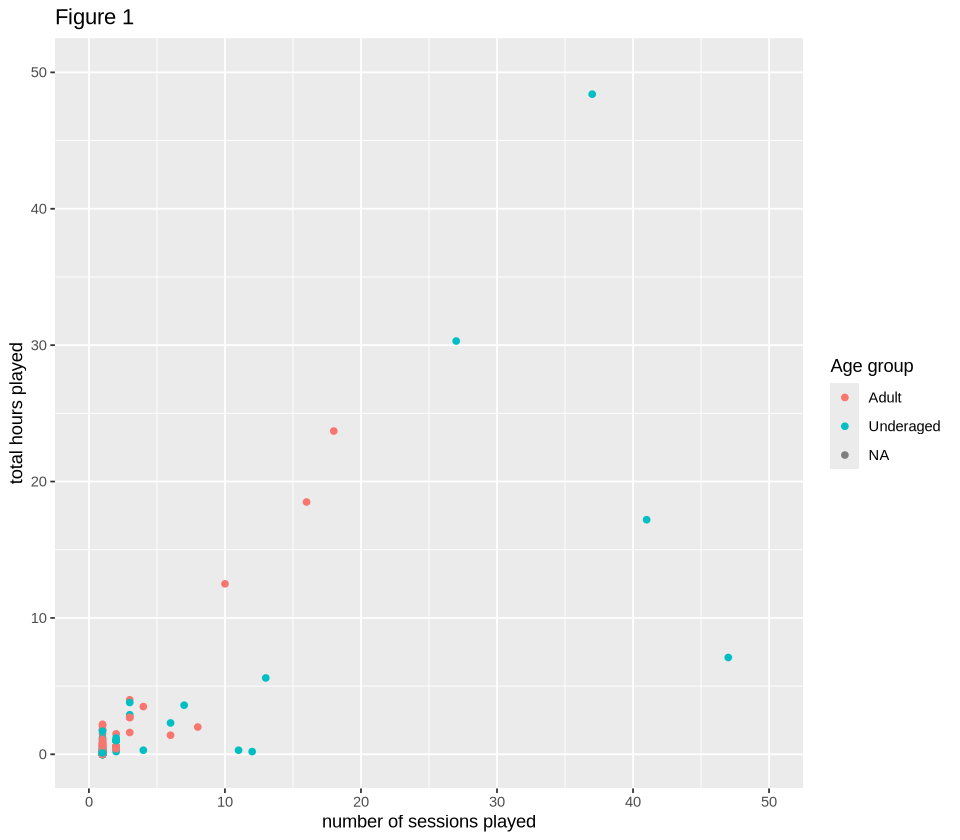

In [169]:
options(repr.plot.width = 8, repr.plot.height = 7)
#first visualization for showing a correlation

session_to_hours_plot <- final_data_players |>
    ggplot(aes(x = num_sessions, y = played_hours, color = age_group)) +
    geom_point() +
    labs(x = 'number of sessions played',
         y = 'total hours played',
         color = 'Age group') +
    ggtitle('Figure 1') +
    xlim(0, 50) +
    ylim(0, 50)

session_to_hours_plot

To address the research question, a supervised machine learning analysis was performed using the tidymodels framework. The process began by partitioning the data to ensure a fair and unbiased evaluation. The dataset was split into a training set, containing 75% of the data, and a testing set with the remaining 25%. This split was stratified on the age_group variable to maintain the same proportion of "Adult" and "Underaged" players in both subsets. The testing set was held out exclusively for the final model evaluation. The k-Nearest Neighbors (k-NN) algorithm was chosen for this classification task. This method is particularly appropriate because the exploratory analysis revealed no simple, linear boundary between the classes, and k-NN's flexible, non-parametric nature allows it to learn complex decision boundaries. The primary assumption of k-NN is that all predictor variables must be on a comparable scale, as the algorithm relies on distance calculations. This was addressed by creating a pre-processing recipe that centered and scaled both the num_sessions and played_hours variables before they were used by the model. While k-NN has potential limitations, such as being computationally intensive on large datasets and susceptible to the "curse of dimensionality," these were not significant concerns for this project's smaller, two-predictor dataset. To select the best model, an analysis was made by testing the number of neigbors from 1 to 20. The model's performance for each k was evaluated using 10-fold cross-validation on the training data, with mean accuracy serving as the selection metric. In the event of a tie, the model with the smallest k value was chosen to favor a more flexible model. Finally, a single optimized model was trained on the entire training dataset using this best-performing value of k, making it ready for a final evaluation.

In [171]:
# split training and testing data
set.seed(3456) 

player_split <- initial_split(final_data_players, prop = .75, strata = age_group)  
player_train <- training(player_split)   
player_test <- testing(player_split)

In [172]:
# model test
set.seed(3456) 

player_recipe <- recipe(age_group ~ num_sessions + played_hours , data = player_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 5) |>
      set_engine('kknn') |>
      set_mode('classification')

player_vfold <- vfold_cv(player_train, v = 10, repeats = 3, strata = age_group)

player_resample_fit <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(knn_spec) |>
      fit_resamples(resamples = player_vfold) 

player_metrics <- collect_metrics(player_resample_fit)
player_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.5626557,30,0.01288988,Preprocessor1_Model1
roc_auc,binary,0.5047950,30,0.01989183,Preprocessor1_Model1


In [173]:
#tune model

set.seed(3456) 

player_vfold <- vfold_cv(player_train, v = 10, strata = age_group)

k_vals <- tibble(neighbors = c(1:20))

knn_tune_spec <- nearest_neighbor(neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_tune_spec)

better_tuning_results <- knn_workflow |>
    tune_grid(resamples = player_vfold, grid = k_vals)

# Or see the best performing values of k
results <- show_best(better_tuning_results, metric = "accuracy")
results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
18,accuracy,binary,0.5788278,10,0.02481120,Preprocessor1_Model18
19,accuracy,binary,0.5788278,10,0.02481120,Preprocessor1_Model19
20,accuracy,binary,0.5788278,10,0.02481120,Preprocessor1_Model20
8,accuracy,binary,0.5716850,10,0.02813787,Preprocessor1_Model08
11,accuracy,binary,0.5716850,10,0.02813787,Preprocessor1_Model11


In [174]:
# select the best model and update the workflow

best_k <- results |>
  filter(.metric == "accuracy") |>
  filter(mean == max(mean)) |>
  arrange(neighbors) |>
  slice(1) |>
  pull(neighbors)

knn_tune_spec_final <- nearest_neighbor(neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

final_knn_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_tune_spec_final)

final_model_fit <- fit(
  final_knn_workflow,
  data = player_train)

final_model_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(18L,     data, 5))

Type of response variable: nominal
Minimal misclassification: 0.4375
Best kernel: optimal
Best k: 18

The k-Nearest Neighbors model built to predict a player's age group based on their session count and playtime achieved a final cross-validation accuracy of approximately 58%. This result is only slightly better than random guessing and refutes the initial hypothesis that "Adult" and "Underaged" players would show distinct engagement patterns.

This finding, while not what was expected, provides a valuable insight for the stakeholders: simple playtime metrics are not effective for distinguishing between these age groups. This can save resources by redirecting recruitment efforts away from this strategy. Future work should therefore focus on more granular data, such as specific in-game actions or other player attributes, and potentially explore more complex models to determine if a stronger predictive signal exists.